In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import argparse
import yaml
from flax.training import train_state, checkpoints
import optax
from functools import partial
import pandas as pd

from irbfn_mpc.dynamics import integrate_st_mult
from irbfn_mpc.model import WCRBFNet
from flax_rbf.flax_rbf import gaussian, inverse_quadratic, gaussian_narrow

from irbfn_mpc.nonlinear_dmpc import NMPCPlanner

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context="talk", style="white", palette="pastel", font="Times New Roman")

In [3]:
# explicit nmpc table
# npz_path = "/data/tables/5v_8x_9y_18t_5vgoal_6beta_12angvz_mu1.0_cs5.0.npz"
npz_path = "/data/tables/5v_19x_24y_18t_5vgoal_6beta_12angvz_mu1.0_cs5.0.npz"
data = np.load(npz_path)
inputs, outputs = data["inputs"], data["outputs"]

In [4]:
@partial(jax.vmap, in_axes=[0, None])
@jax.jit
def get_closest_ind(input, all_inputs):
    diff = all_inputs - input
    ind = jnp.argmin(jnp.linalg.norm(diff, axis=1))
    return ind

In [5]:
# old ckpt, 0 is boundary, poor performance on the edge
# config_f = "configs/dnmpc_1regions_newdata_oldintloss_nomirror_highk.yaml"
# ckpt = "ckpts/dnmpc_1regions_newdata_oldintloss_nomirror_highk/checkpoint_999"

# good l1 one
# config_f = "configs/dnmpc_1regions_newnewdata_l1.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_l1/checkpoint_6200"

# good l2 one
# config_f = "configs/dnmpc_1regions_newnewdata.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata/checkpoint_5800"

# l1 1 step int
# config_f = "configs/dnmpc_1regions_newnewdata_1stepl1.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_1stepl1/checkpoint_8400"

# config_f = "configs/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_gn.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_gn/checkpoint_7000"

# config_f = "configs/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_iq.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_iq/checkpoint_5200"

config_f = "configs/dnmpc_1regions_newnewdata_1stepst_l2_newarch_ksint.yaml"
ckpt = "ckpts/dnmpc_1regions_newnewdata_1stepst_l2_newarch_ksint/checkpoint_3900"

# config_f = "configs/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_dv.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_1stepst_l1_newarch_ksint_dv/checkpoint_100"


# lower training loss one
# config_f = "configs/dnmpc_1regions_newnewdata_huber0.05.yaml"
# ckpt = "ckpts/dnmpc_1regions_newnewdata_huber0.05/checkpoint_2700"

with open(config_f, "r") as f:
    config_dict = yaml.safe_load(f)
conf = argparse.Namespace(**config_dict)

wcrbf = WCRBFNet(
    in_features=conf.in_features,
    out_features=conf.out_features,
    num_kernels=conf.num_kernels,
    basis_func=eval(conf.basis_func),
    num_regions=conf.num_regions,
    lower_bounds=conf.lower_bounds,
    upper_bounds=conf.upper_bounds,
    dimension_ranges=conf.dimension_ranges,
    activation_idx=conf.activation_idx,
    delta=conf.delta,
)
rng = jax.random.PRNGKey(conf.seed)
rng, init_rng = jax.random.split(rng)
params = wcrbf.init(init_rng, jnp.ones((1, conf.in_features)))
optim = optax.chain(optax.clip_by_global_norm(0.1), optax.adam(conf.lr))
state = train_state.TrainState.create(
    apply_fn=wcrbf.apply, params=params, tx=optim
)
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=ckpt, target=state
)

2024-09-06 01:48:35.706884: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
@jax.jit
def pred_step(state, x):
    y = state.apply_fn(state.params, x)
    return y

In [7]:
# goal grid on xy
r_goal_x = np.linspace(0.0, 3.5, 20) + 0.036
r_goal_y = np.linspace(0.0, 3.5, 20) + 0.036
r_gx_m, r_gy_m = np.meshgrid(r_goal_x, r_goal_y, indexing="ij")
rgx = r_gx_m.flatten()
rgy = r_gy_m.flatten()
zs = np.zeros_like(rgx)
vc = 0.9 * np.ones_like(rgx)
vg = 3.0 * np.ones_like(rgx)
tg = np.mod(-1.3 * np.ones_like(rgx), np.pi)

# inputs
test_inputs = np.column_stack((zs, rgx, rgy, tg, vg, zs, zs))
test_inputs_dv = np.column_stack((rgx, rgy, tg, vg - zs, zs, zs))

In [8]:
import chex
chex.clear_trace_counter()

In [9]:
# output from irbfn
pred_u_irbfn = pred_step(restored_state, test_inputs)
# pred_u_irbfn = pred_step(restored_state, test_inputs_dv)

In [10]:
# output from explicit table
inds_explicit = get_closest_ind(test_inputs, inputs)
pred_u_explicit = outputs[inds_explicit].reshape((-1, 10), order="F")

In [11]:
errors = pred_u_irbfn - pred_u_explicit[:, [0, 5]]
# errors = pred_u_irbfn - pred_u_explicit

In [12]:
first_accl_actual_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "accl_0": pred_u_explicit[:,  0]}, columns=["x", "y", "accl_0"])
first_sv_actual_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "sv_0": pred_u_explicit[:, 5]}, columns=["x", "y", "sv_0"])
first_accl_predicted_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "accl_0": pred_u_irbfn[:,  0]}, columns=["x", "y", "accl_0"])
first_sv_predicted_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "sv_0": pred_u_irbfn[:, 5]}, columns=["x", "y", "sv_0"])


In [13]:
first_accl_actual_df = first_accl_actual_df.pivot(index="y", columns="x", values="accl_0")
first_sv_actual_df = first_sv_actual_df.pivot(index="y", columns="x", values="sv_0")
first_accl_predicted_df = first_accl_predicted_df.pivot(index="y", columns="x", values="accl_0")
first_sv_predicted_df = first_sv_predicted_df.pivot(index="y", columns="x", values="sv_0")

Text(0.5, 1.0, 'Actual First Accl')

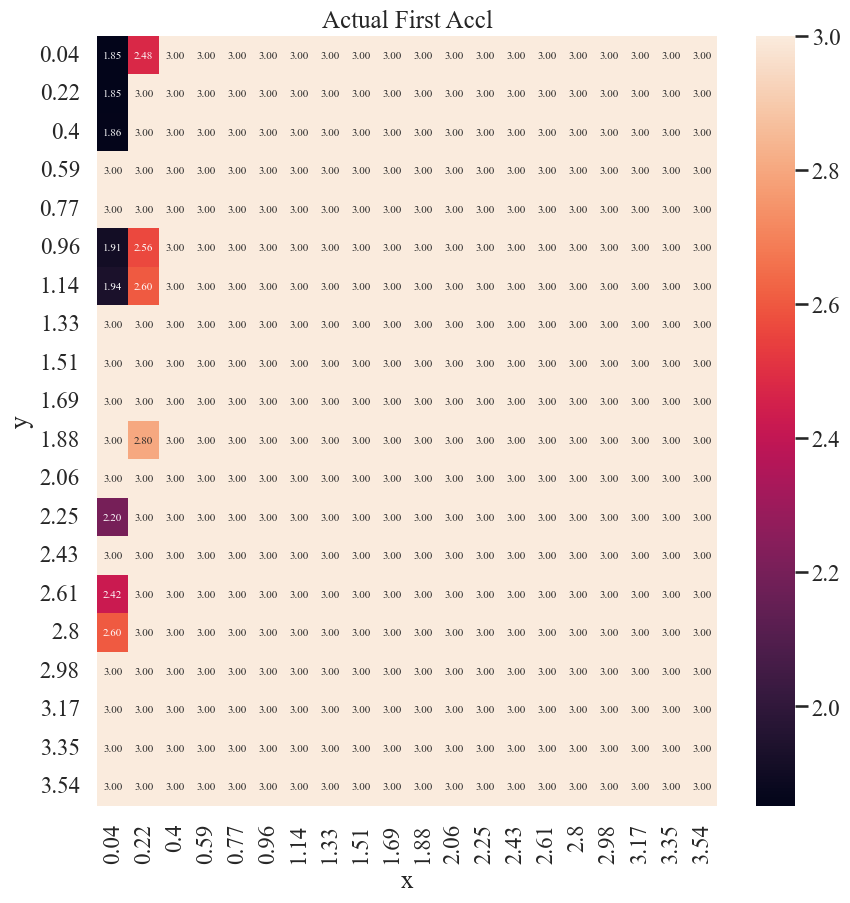

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_actual_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_actual_df.columns.values.round(2), yticklabels=first_accl_actual_df.index.values.round(2))
plt.title("Actual First Accl")

Text(0.5, 1.0, 'Actual First SV')

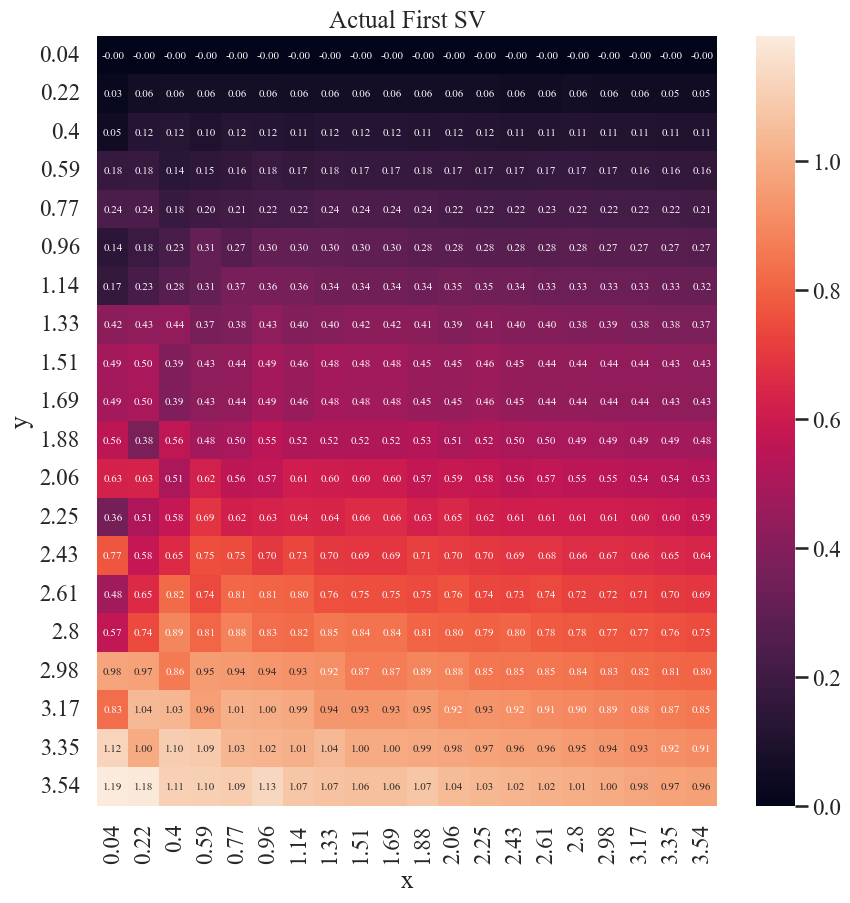

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_sv_actual_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_sv_actual_df.columns.values.round(2), yticklabels=first_sv_actual_df.index.values.round(2))
plt.title("Actual First SV")

Text(0.5, 1.0, 'Predicted First Accl')

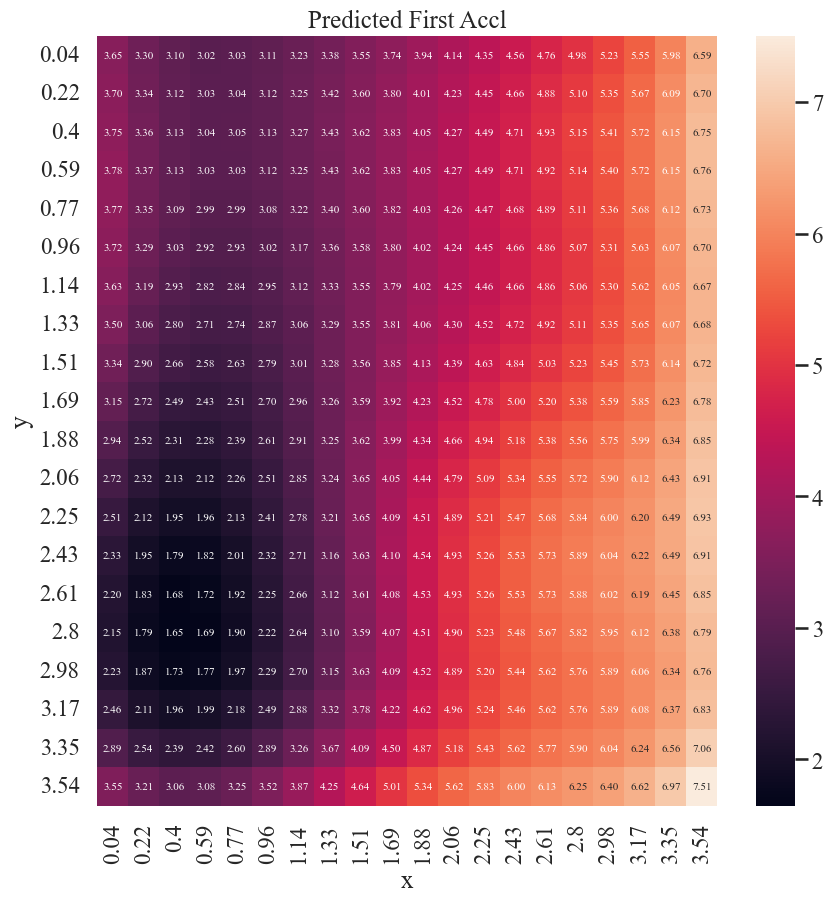

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_predicted_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_predicted_df.columns.values.round(2), yticklabels=first_accl_predicted_df.index.values.round(2))
plt.title("Predicted First Accl")

Text(0.5, 1.0, 'Predicted First SV')

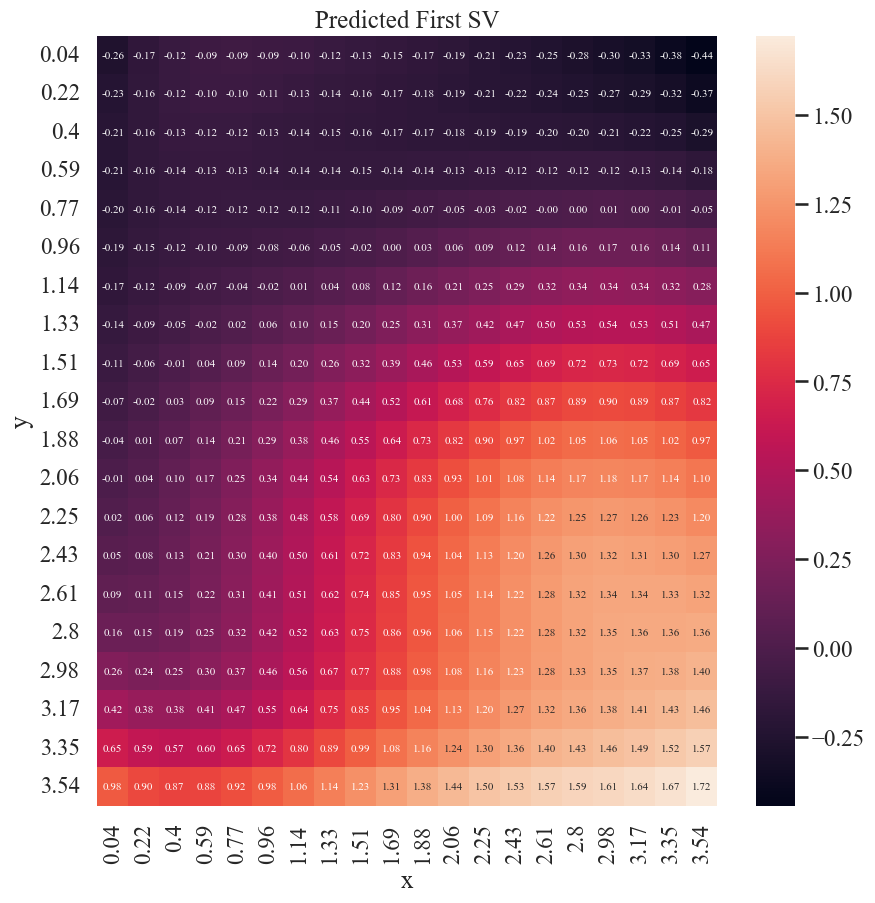

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_sv_predicted_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_sv_predicted_df.columns.values.round(2), yticklabels=first_sv_predicted_df.index.values.round(2))
plt.title("Predicted First SV")

In [18]:
df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "err": list(errors)}, columns=["x", "y", "err"])

In [19]:
first_accl_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "err": errors[:, 0]}, columns=["x", "y", "err"])

In [20]:
first_accl_df = first_accl_df.pivot(index="y", columns="x", values="err")

Text(0.5, 1.0, 'First acceleration input error against LUT')

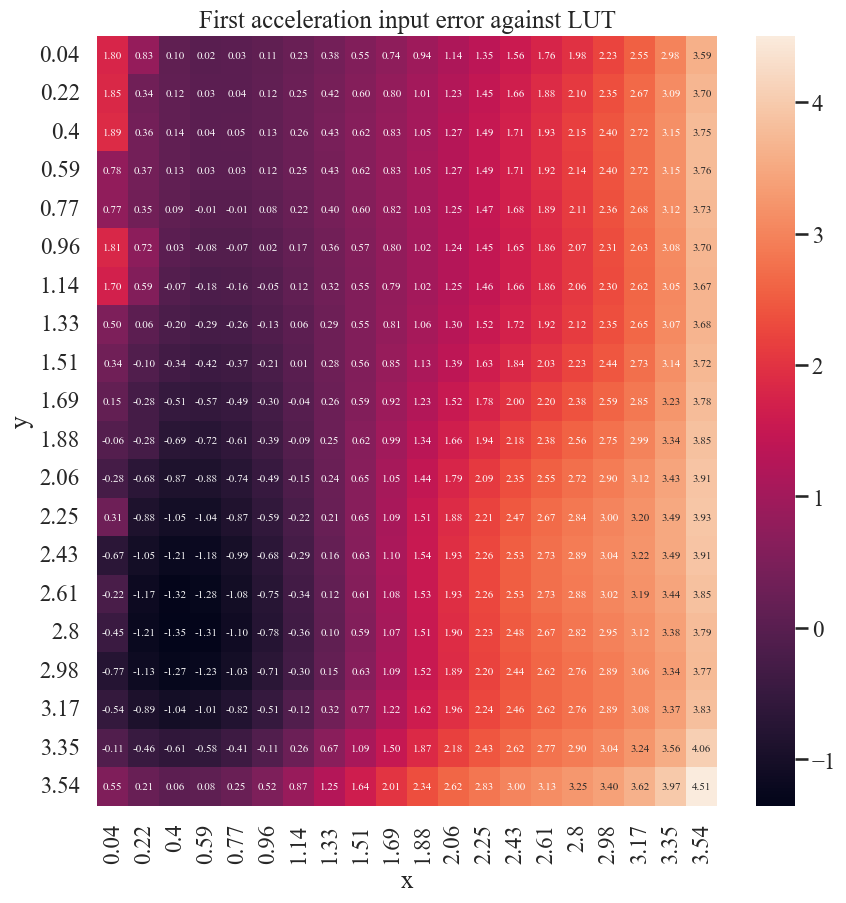

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_accl_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_accl_df.columns.values.round(2), yticklabels=first_accl_df.index.values.round(2))
plt.title("First acceleration input error against LUT")

In [22]:
first_vs_df = pd.DataFrame({"x": test_inputs[:, 1], "y": test_inputs[:, 2], "err": errors[:, 5]}, columns=["x", "y", "err"])

In [23]:
first_vs_df = first_vs_df.pivot(index="y", columns="x", values="err")

Text(0.5, 1.0, 'First steering velocity input error against LUT')

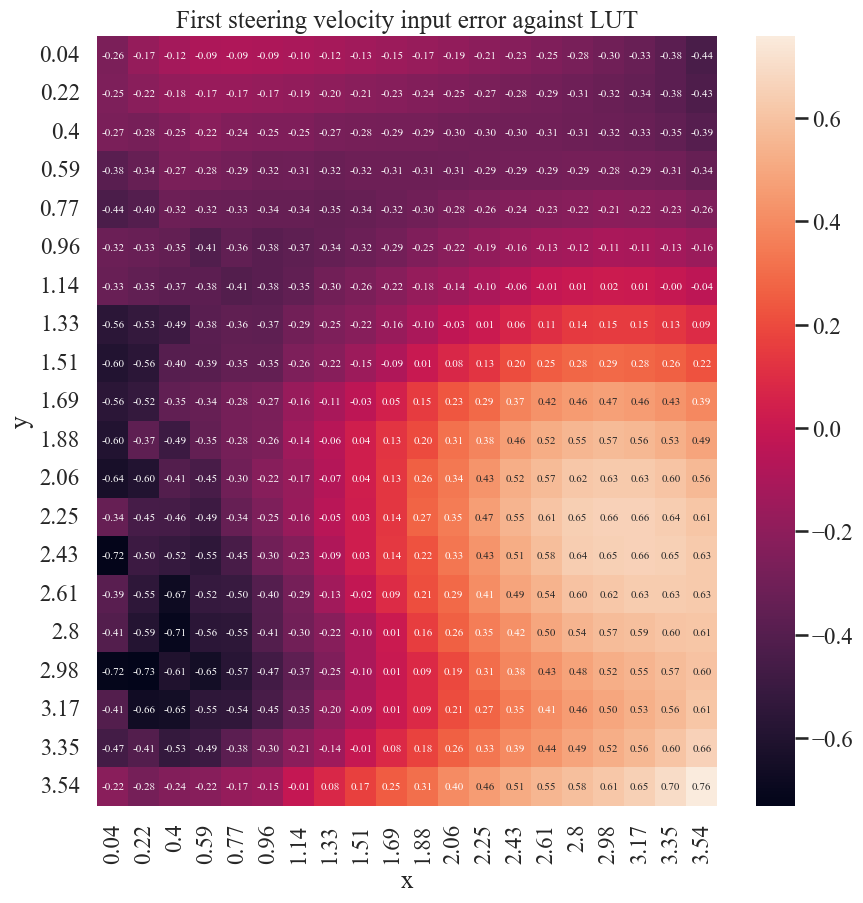

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(first_vs_df.round(3), annot=True, annot_kws={"fontsize":8}, fmt=".2f", xticklabels=first_vs_df.columns.values.round(2), yticklabels=first_vs_df.index.values.round(2))
plt.title("First steering velocity input error against LUT")